
=== Loading Dataset ===
   Unnamed: 0  acousticness  danceability  duration_ms  energy  \
0           0        0.0102         0.833       204600   0.434   
1           1        0.1990         0.743       326933   0.359   
2           2        0.0344         0.838       185707   0.412   
3           3        0.6040         0.494       199413   0.338   
4           4        0.1800         0.678       392893   0.561   

   instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0          0.021900    2    0.1650    -8.795     1       0.4310  150.062   
1          0.006110    1    0.1370   -10.401     1       0.0794  160.083   
2          0.000234    2    0.1590    -7.148     1       0.2890   75.044   
3          0.510000    5    0.0922   -15.236     1       0.0261   86.468   
4          0.512000    5    0.4390   -11.648     0       0.0694  174.004   

   time_signature  valence  target      song_title            artist  
0             4.0    0.286       1        Mask Off

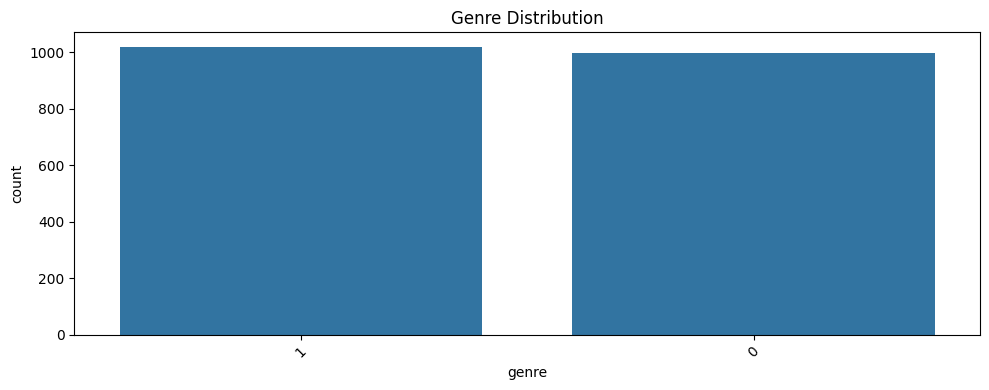

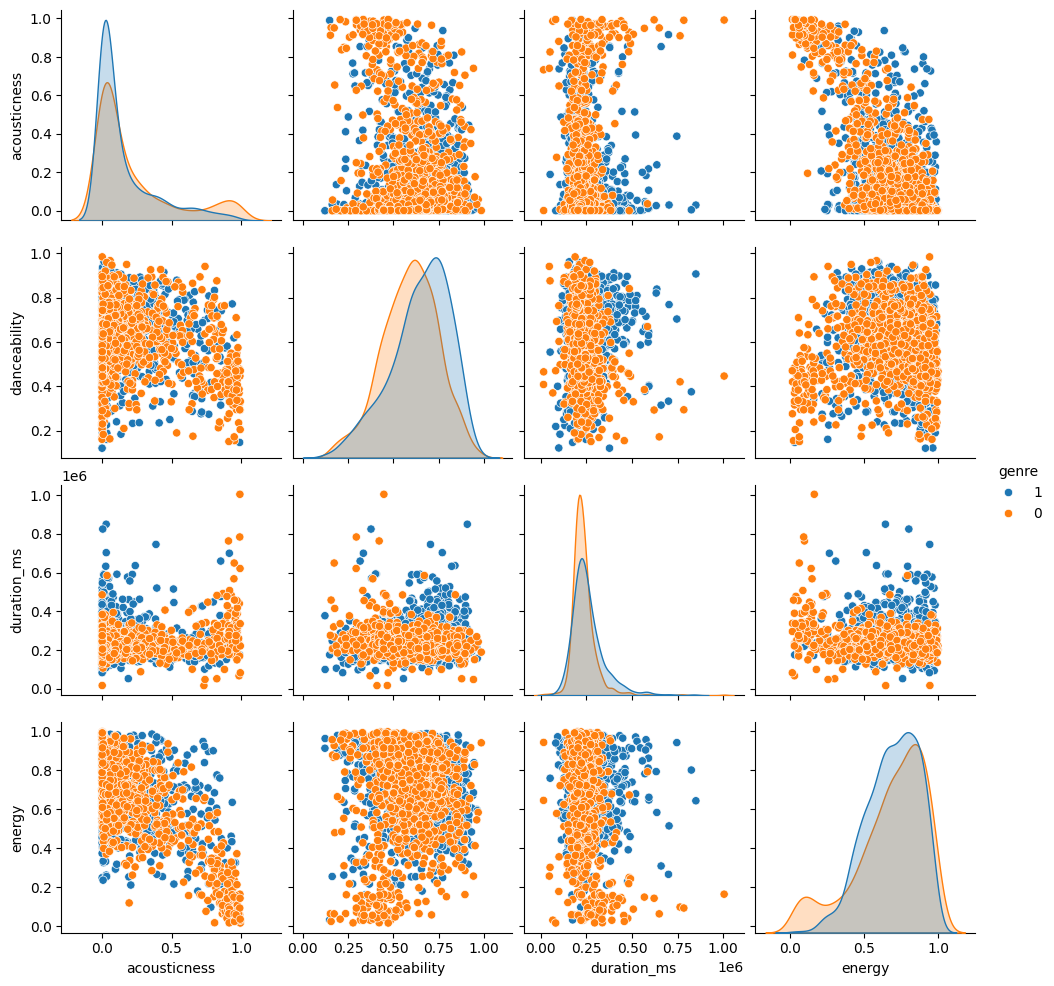

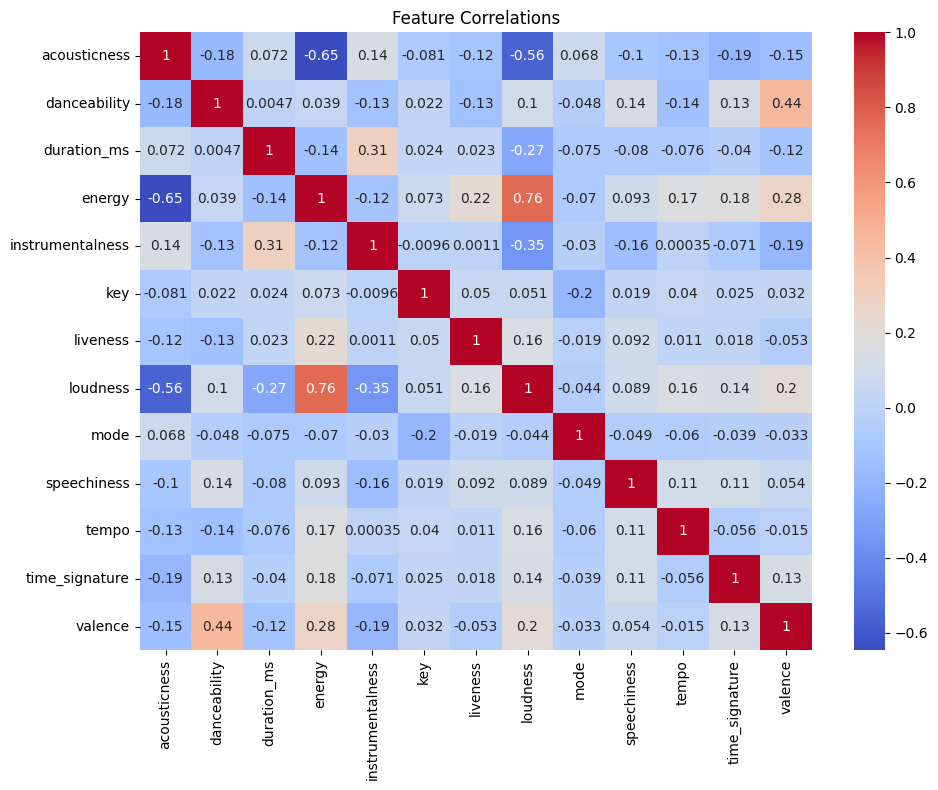

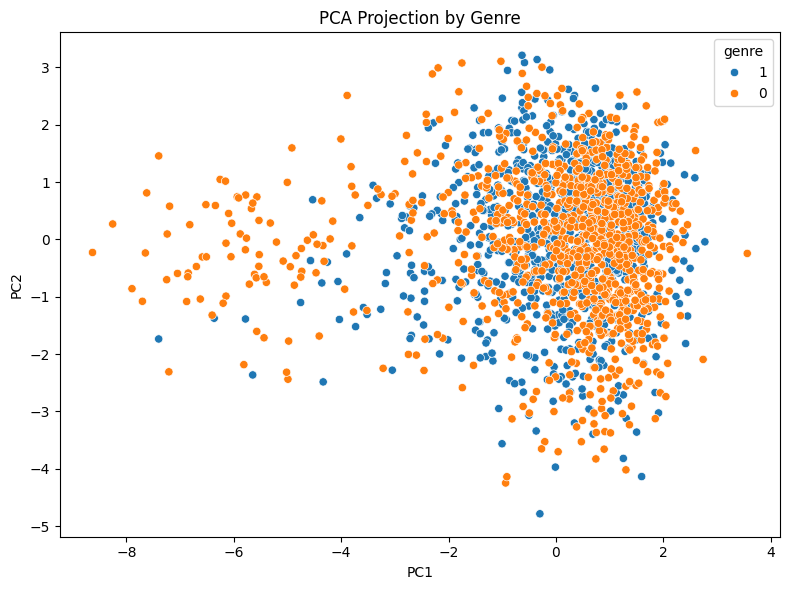

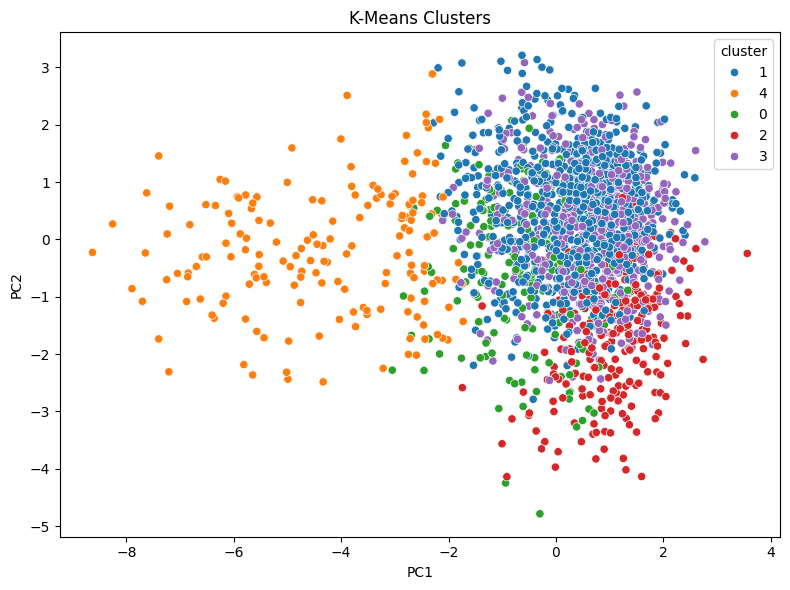


=== Crosstab (Genre vs Cluster)===
cluster    0    1    2    3    4
genre                           
0         31  449  133  262  122
1        177  386  124  284   49

Saved processed dataset ➜ "songs_processed.csv"


In [3]:


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

print("\n=== Loading Dataset ===")
df = pd.read_csv('data.csv')
print(df.head())

print("\n=== Dataset Info ===")
print(df.info())

print("\n=== Statistics ===")
print(df.describe())

# If 'genre' is missing, create it from 'target' (fallback)
if "genre" not in df.columns:
    # Use string labels so plotting treats it as categorical
    df["genre"] = df["target"].astype(str)
    print('\nNote: "genre" column was missing — created from "target".')

# =======================
# 1. Genre distribution
# =======================
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x="genre", order=df["genre"].value_counts().index)
plt.title("Genre Distribution")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# =======================
# 2. Numeric features
# =======================
# Exclude label/index columns from numeric features used for EDA/ML
exclude_cols = {"target", "Unnamed: 0"}
num_cols = [c for c in df.select_dtypes(include="number").columns if c not in exclude_cols]

if len(num_cols) > 1:
    sns.pairplot(df, vars=num_cols[:4], hue="genre", diag_kind="kde")
    plt.show()
else:
    print("\nNot enough numeric feature columns for pairplot/PCA/KMeans.")

# =======================
# 3. Correlation heatmap
# =======================
if len(num_cols) > 0:
    plt.figure(figsize=(10, 8))
    sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm")
    plt.title("Feature Correlations")
    plt.tight_layout()
    plt.show()

# =======================
# 4. PCA Visualization
# =======================
if len(num_cols) >= 2:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[num_cols])

    pca = PCA(n_components=2)
    pca_components = pca.fit_transform(X_scaled)

    df["PC1"] = pca_components[:, 0]
    df["PC2"] = pca_components[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="genre")
    plt.title("PCA Projection by Genre")
    plt.tight_layout()
    plt.show()

    # =======================
    # 5. K-Means Clustering
    # =======================
    kmeans = KMeans(n_clusters=5, random_state=42)
    df["cluster"] = kmeans.fit_predict(X_scaled).astype(str)  # as str for categorical hue

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="cluster", palette="tab10")
    plt.title("K-Means Clusters")
    plt.tight_layout()
    plt.show()

    print("\n=== Crosstab (Genre vs Cluster)===")
    print(pd.crosstab(df["genre"], df["cluster"]))
else:
    print("\nSkipping PCA and KMeans due to insufficient numeric features.")

df.to_csv("songs_processed.csv", index=False)
print('\nSaved processed dataset ➜ "songs_processed.csv"')
